In [10]:
!pip install gensim

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
from google.colab import files
uploaded = files.upload()

Saving SMSSpamCollection to SMSSpamCollection (1)


In [13]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def load_and_preprocess(path):
    df = pd.read_csv(path, sep='\t', header=None, names=['label', 'text'])
    df['clean_text'] = df['text'].apply(clean_text)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    return df

In [14]:
df = load_and_preprocess("SMSSpamCollection")
df.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


label
0    4825
1     747
Name: count, dtype: int64


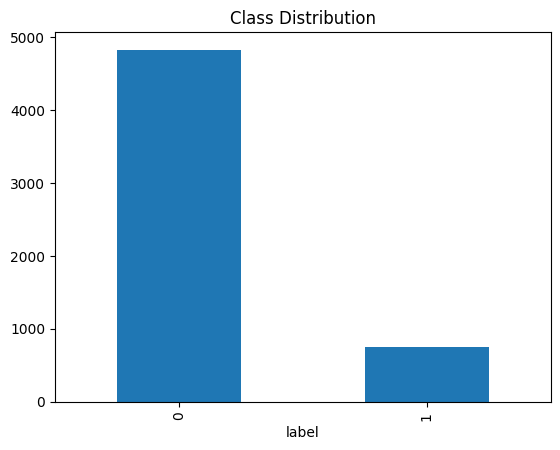

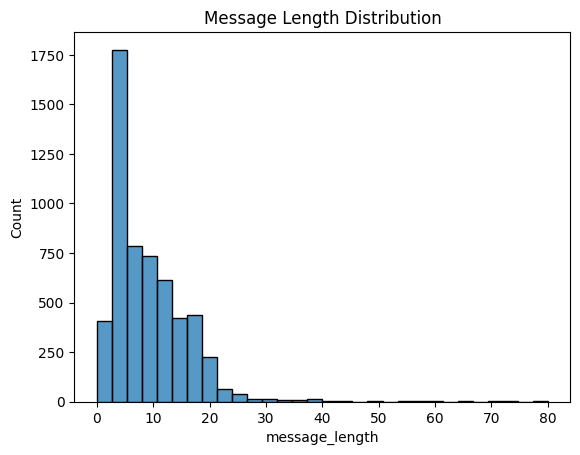

In [15]:
print(df['label'].value_counts())

df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.show()

df['message_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['message_length'], bins=30)
plt.title("Message Length Distribution")
plt.show()

In [16]:
!pip install gensim

In [17]:
results = []

def full_evaluate(model, X_test, y_test, name):
    preds = (model.predict(X_test) > 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    print("\n===== " + name + " =====")
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    results.append(["LSTM", name, acc, prec, rec, f1])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8363 - loss: 0.6131 - val_accuracy: 0.8520 - val_loss: 0.3624
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8842 - loss: 0.2903 - val_accuracy: 0.9036 - val_loss: 0.2328
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9361 - loss: 0.1792 - val_accuracy: 0.9439 - val_loss: 0.1716
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9641 - loss: 0.1189 - val_accuracy: 0.9484 - val_loss: 0.1442
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9697 - loss: 0.0987 - val_accuracy: 0.9552 - val_loss: 0.1306
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9731 - loss: 0.0894 - val_accuracy: 0.9552 - val_loss: 0.1249
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9715 - loss: 0.0868 - val_accuracy: 0.9552 - val_loss: 0.1205
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9775 - loss: 0.0708 - val_accur

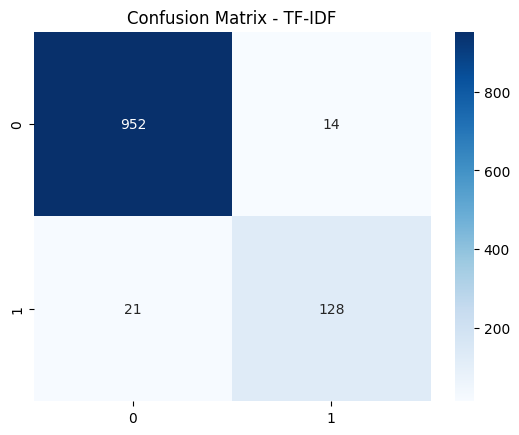

In [18]:
X = df['clean_text']
y = df['label']

vectorizer = TfidfVectorizer(max_features=300)
X_tfidf = vectorizer.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

model_tfidf = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_tfidf.compile(loss='binary_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

history = model_tfidf.fit(X_train, y_train,
                          validation_split=0.1,
                          epochs=10,
                          batch_size=32)

full_evaluate(model_tfidf, X_test, y_test, "TF-IDF")


In [19]:
sentences = [text.split() for text in df['clean_text']]

skipgram = Word2Vec(sentences, vector_size=100, window=5, sg=1, min_count=2)
cbow = Word2Vec(sentences, vector_size=100, window=5, sg=0, min_count=2)

skipgram.save("word2vec_skipgram.model")
cbow.save("word2vec_cbow.model")


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.8927 - loss: 0.3392 - val_accuracy: 0.9596 - val_loss: 0.1127
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9691 - loss: 0.1017 - val_accuracy: 0.9574 - val_loss: 0.1088
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9710 - loss: 0.0898 - val_accuracy: 0.9507 - val_loss: 0.1061
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9710 - loss: 0.0906 - val_accuracy: 0.9596 - val_loss: 0.1094
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9728 - loss: 0.0892 - val_accuracy: 0.9596 - val_loss: 0.1180
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9695 - loss: 0.0896 - val_accuracy: 0.9619 - val_loss: 0.1074
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9753 - loss: 0.0803 - val_accuracy: 0.9574 - val_loss: 0.1066
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9723 - loss: 0.0798 - val_acc

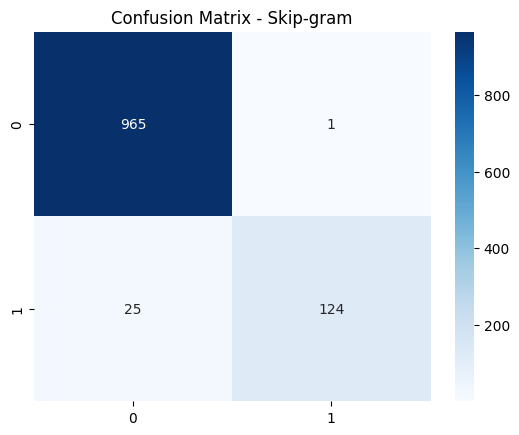

In [20]:
model_w2v = Word2Vec.load("word2vec_skipgram.model")

word_index = {word: i+1 for i, word in enumerate(model_w2v.wv.index_to_key)}

sequences = [[word_index.get(w, 0) for w in s.split()] for s in df['clean_text']]
X = pad_sequences(sequences, maxlen=50)

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

embedding_matrix = np.zeros((len(word_index)+1, 100))

for word, i in word_index.items():
    embedding_matrix[i] = model_w2v.wv[word]

model_skip = Sequential([
    Embedding(len(word_index)+1, 100,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_skip.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_skip.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)

full_evaluate(model_skip, X_test, y_test, "Skip-gram")


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8583 - loss: 0.4324 - val_accuracy: 0.8453 - val_loss: 0.3691
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8696 - loss: 0.3071 - val_accuracy: 0.8498 - val_loss: 0.3250
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8705 - loss: 0.2963 - val_accuracy: 0.8655 - val_loss: 0.3169
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8751 - loss: 0.2905 - val_accuracy: 0.8677 - val_loss: 0.3167
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8767 - loss: 0.2848 - val_accuracy: 0.8520 - val_loss: 0.3188
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8704 - loss: 0.2912 - val_accuracy: 0.8430 - val_loss: 0.3254
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8708 - loss: 0.2892 - val_accuracy: 0.8857 - val_loss: 0.2964
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8774 - loss: 0.2865 - val_accu

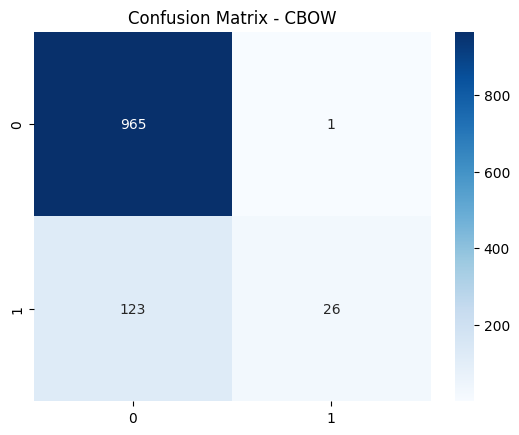

In [21]:
model_w2v = Word2Vec.load("word2vec_cbow.model")

word_index = {word: i+1 for i, word in enumerate(model_w2v.wv.index_to_key)}

sequences = [[word_index.get(w, 0) for w in s.split()] for s in df['clean_text']]
X = pad_sequences(sequences, maxlen=50)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

embedding_matrix = np.zeros((len(word_index)+1, 100))

for word, i in word_index.items():
    embedding_matrix[i] = model_w2v.wv[word]

model_cbow = Sequential([
    Embedding(len(word_index)+1, 100,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_cbow.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cbow.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)

full_evaluate(model_cbow, X_test, y_test, "CBOW")


In [22]:
df_results = pd.DataFrame(results, columns=["Model", "Embedding", "Accuracy", "Precision", "Recall", "F1"])
df_results


,Model,Embedding,Accuracy,Precision,Recall,F1
0,LSTM,TF-IDF,0.968610,0.901408,0.859060,0.879725
1,LSTM,Skip-gram,0.976682,0.992000,0.832215,0.905109
2,LSTM,CBOW,0.888789,0.962963,0.174497,0.295455


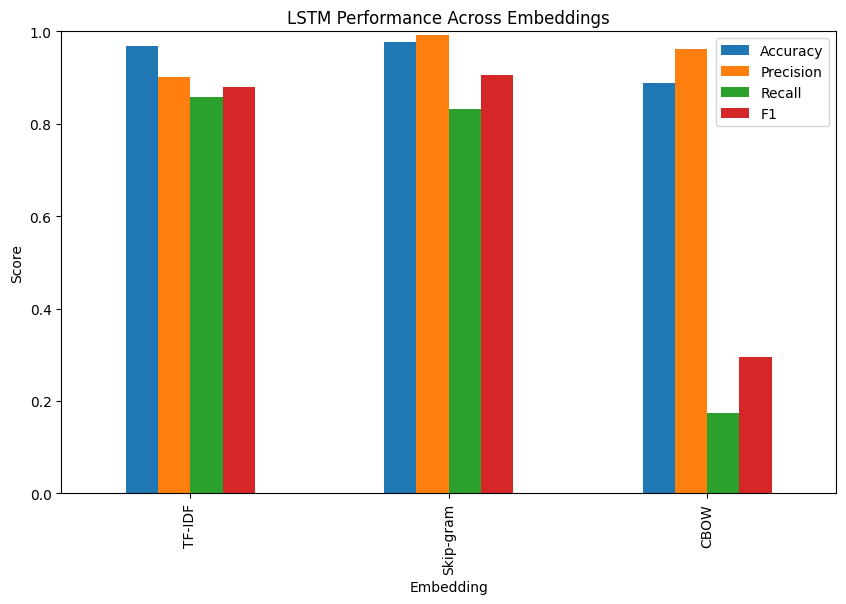

In [23]:
df_results.set_index("Embedding")[["Accuracy", "Precision", "Recall", "F1"]].plot(kind="bar", figsize=(10,6))
plt.title("LSTM Performance Across Embeddings")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7756 - loss: 0.5096
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8627 - loss: 0.3265
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8640 - loss: 0.3084
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8683 - loss: 0.3115
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8639 - loss: 0.2996
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

===== Skipgram LSTM-32 =====
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

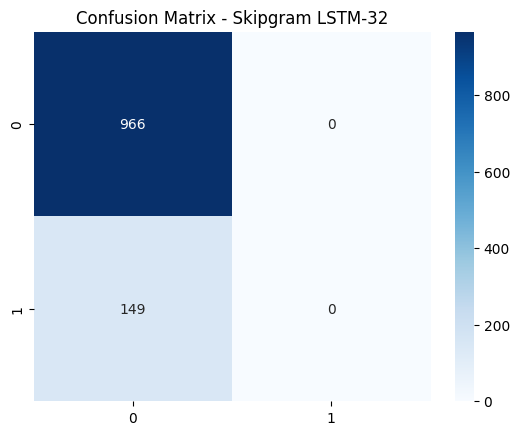

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8303 - loss: 0.4328
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8633 - loss: 0.3156
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8584 - loss: 0.3163
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8633 - loss: 0.3061
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8670 - loss: 0.3040
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

===== Skipgram LSTM-64 =====
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       1.00      0.01      0.01       149

    accuracy                           0.87      1115
   macro avg       0.93      0.50      0.47      1115
weighted avg       0.88      0.87      0.81      1115



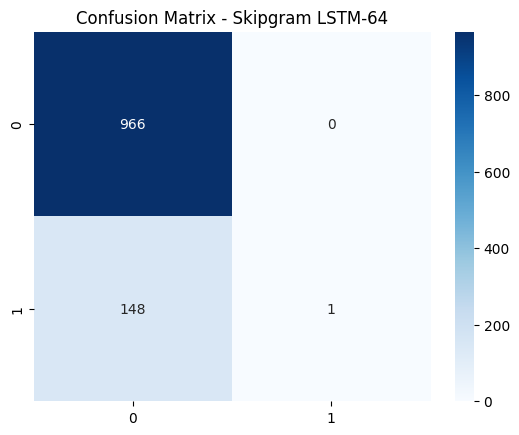

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.8638 - loss: 0.4005
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.8660 - loss: 0.2993
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.8659 - loss: 0.2942
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.8678 - loss: 0.2928
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.8801 - loss: 0.2862
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

===== Skipgram LSTM-128 =====
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.85      0.07      0.14       149

    accuracy                           0.87      1115
   macro avg       0.86      0.54      0.53      1115
weighted avg       0.87      0.87      0.83      1115



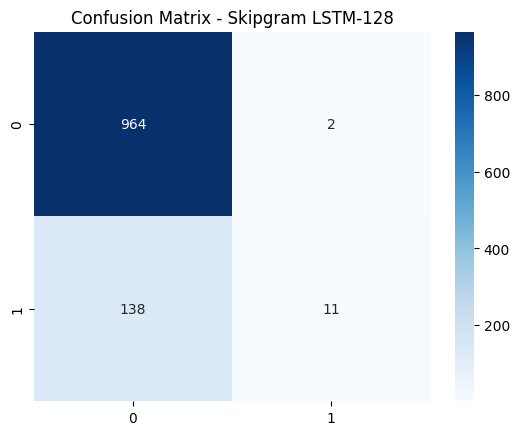

In [24]:
for units in [32, 64, 128]:
    temp_model = Sequential([
        Embedding(len(word_index)+1, 100, weights=[embedding_matrix], trainable=False),
        LSTM(units),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    temp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    temp_model.fit(X_train, y_train, epochs=5, batch_size=32)

    full_evaluate(temp_model, X_test, y_test, f"Skipgram LSTM-{units}")
